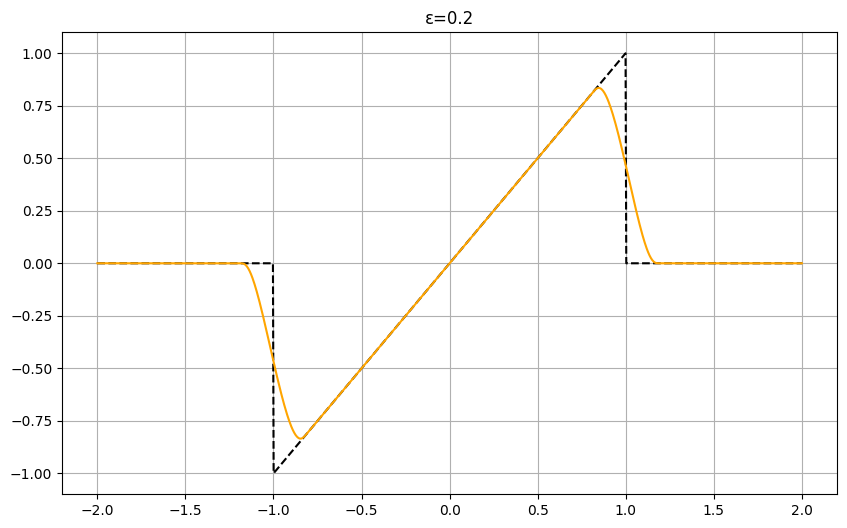

In [ ]:
# BUMP MOLLIFIER

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Define the compactly supported bump mollifier
def bump_mollifier(y, epsilon):
    if np.abs(y) < 1:
        return (1 / epsilon) * np.exp(1 / ((y / epsilon)**2 - 1))
    else:
        return 0

def calculate_normalization_constant(epsilon):
    function = lambda x: bump_mollifier(x, epsilon)
    result, _ = quad(function, -epsilon, epsilon)
    return 1 / result

# Optimized normalized bump mollifier
def optimized_bump_mollifier(y, epsilon, normalization_constant):
    if np.abs(y) < epsilon:
        return bump_mollifier(y, epsilon) * normalization_constant
    else:
        return 0

# Define the smoothed function using a given mollifier
def mollify(x, epsilon, f, mollifier, *args):
    function = lambda y: f(x - y) * mollifier(y, epsilon, *args)
    result, _ = quad(function, -epsilon, epsilon)  # Approximate over a finite range
    return result


x_values = np.linspace(-2, 2, 1000)

# ε 
epsilon_value = 0.2

# Constante de normalização
bump_constant = calculate_normalization_constant(epsilon_value)

# função a ser molificada
def u(x):
    if x <= 1 and x >= -1:
        return x
    else:
        return 0

# Molificando a função, para cada x no domínio faz a convolução
bump_values = [mollify(x, epsilon_value, u, optimized_bump_mollifier, bump_constant) for x in x_values]
y = [u(x) for x in x_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y, label="|x| (original)", color="black", linestyle="--")
plt.plot(x_values, bump_values, label="Smoothed |x| (Bump Mollifier)", color="orange")

plt.title(f"ε={epsilon_value}")
plt.grid(True)
plt.show()

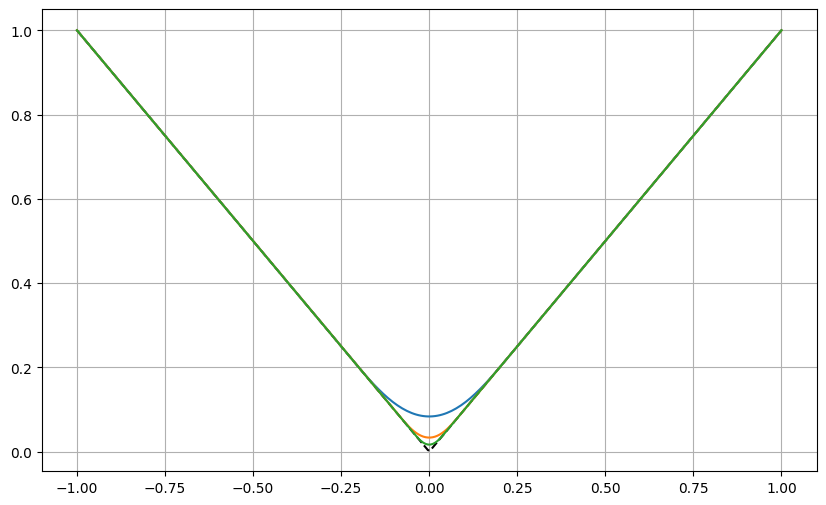

In [3]:
# BUMP MOLLIIFER FOR 3 ε VALUES

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# FUNÇÃO MOLIFICADORA
def bump_mollifier(y, epsilon):
    if np.abs(y) < epsilon:
        return (1 / epsilon) * np.exp(1 / ((y / epsilon)**2 - 1))
    else:
        return 0

# Calculate the normalization constant for the bump mollifier
def calculate_normalization_constant(epsilon):
    integrand = lambda x: bump_mollifier(x, epsilon)
    result, _ = quad(integrand, -epsilon, epsilon)
    return 1 / result

# Optimized normalized bump mollifier
def optimized_bump_mollifier(y, epsilon, normalization_constant):
    if np.abs(y) < epsilon:
        return bump_mollifier(y, epsilon) * normalization_constant
    else:
        return 0

# Define the smoothed |x| function using a given mollifier
def mollify(x, epsilon, mollifier, *args):
    integrand = lambda y: np.abs(x - y) * mollifier(y, epsilon, *args)
    result, _ = quad(integrand, -10, 10)
    return result

# Range of x values
x_values = np.linspace(-1, 1, 300)

# Realizando a convolução
bump_values_1 = [mollify(x, 0.25, optimized_bump_mollifier, calculate_normalization_constant(0.25)) for x in x_values]
bump_values_2 = [mollify(x, 0.1, optimized_bump_mollifier, calculate_normalization_constant(0.1)) for x in x_values]
bump_values_3 = [mollify(x, 0.05, optimized_bump_mollifier, calculate_normalization_constant(0.005)) for x in x_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, np.abs(x_values), label="|x| (original)", color="black", linestyle="--")
plt.plot(x_values, bump_values_1, label="Smoothed |x| (Bump Mollifier)")
plt.plot(x_values, bump_values_2, label="Smoothed |x| (Bump Mollifier)")
plt.plot(x_values, bump_values_3, label="Smoothed |x| (Bump Mollifier)")

# Customize plot
plt.grid(True)
plt.show()

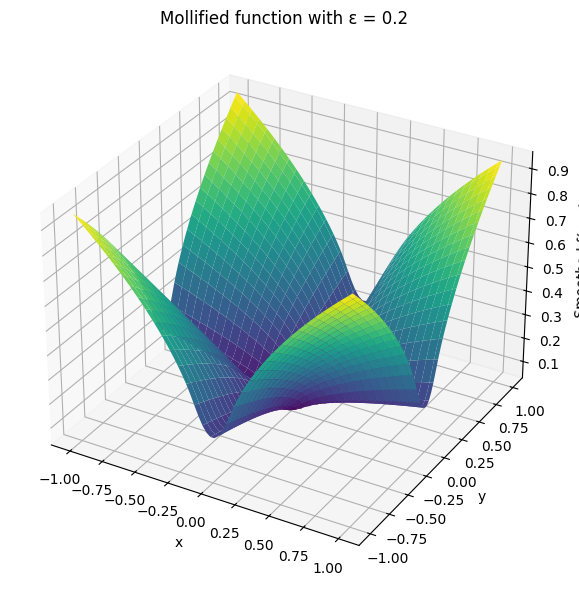

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.signal import convolve2d

# 2D bump mollifier (compact support in disk of radius epsilon)
def bump_mollifier_2d(y1, y2, epsilon):
    r = (y1 / epsilon)**2 + (y2 / epsilon)**2
    if r < 1:
        return (1 / (epsilon**2)) * np.exp(1 / (r - 1))
    else:
        return 0

# Compute normalization constant for 2D mollifier over a disk
def calculate_normalization_constant_2d(epsilon):
    integrand = lambda y2, y1: bump_mollifier_2d(y1, y2, epsilon)
    result, _ = dblquad(
        integrand, 
        -epsilon, 
        epsilon,
        lambda y1: -np.sqrt(epsilon**2 - y1**2),
        lambda y1: np.sqrt(epsilon**2 - y1**2)
    )
    return 1 / result

# Normalized 2D mollifier
def normalized_bump_mollifier_2d(y1, y2, epsilon, normalization_constant):
    r = (y1 / epsilon)**2 + (y2 / epsilon)**2
    if r < 1:
        return normalization_constant * (1 / (epsilon**2)) * np.exp(1 / (r - 1))
    else:
        return 0

def mollify_2d(x, y, epsilon, f, mollifier, normalization_constant):
    # Define a local grid around (x, y)
    grid_size = 2 * int(np.ceil(epsilon / 0.01)) + 1  # controls resolution
    dx = 2 * epsilon / (grid_size - 1)
    offset = np.linspace(-epsilon, epsilon, grid_size)
    Y1, Y2 = np.meshgrid(offset, offset)

    # Compute mollifier values on the grid
    mollifier_grid = np.vectorize(lambda y1, y2: mollifier(y1, y2, epsilon, normalization_constant))(Y1, Y2)

    # Sample the function on the translated grid
    f_grid = np.vectorize(lambda y1, y2: f(x - y1, y - y2))(Y1, Y2)

    # Perform discrete convolution (dot product of aligned grids)
    smoothed_value = np.sum(f_grid * mollifier_grid) * dx * dx
    return smoothed_value


# Define the function f(x, y)
def f(x, y):
    return (np.abs(x) * np.abs(y))**0.5

# Grid setup
x = np.linspace(-1, 1, 70)
y = np.linspace(-1, 1, 70)
X, Y = np.meshgrid(x, y)

epsilon = 0.2
normalization_constant = calculate_normalization_constant_2d(epsilon)

# Compute mollified values
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = mollify_2d(X[i, j], Y[i, j], epsilon, f, normalized_bump_mollifier_2d, normalization_constant)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title(f"ε = {epsilon}")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Smoothed f(x, y)")

plt.tight_layout()
plt.show()  

In [ ]:
# BUMP MOLLIFIER IN R² WITH PLOTLY

import numpy as np
import plotly.graph_objects as go
from scipy.signal import convolve2d


# Generate the grid for the function
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
Z_origial = f(X, Y)



# Plot the original function
fig = go.Figure()

# Original function
fig.add_trace(
    go.Surface(
        z=Z_origial,
        x=X,
        y=Y,
        colorscale='Viridis',
        name=r'Original $f(x, y)$'
    )
)

# Smoothed function
fig.add_trace(
    go.Surface(
        z=Z,
        x=X,
        y=Y,
        colorscale='Plasma',
        name=f'Smoothed with ε={epsilon}',
        showscale=False
    )
)

# Update layout for interactivity
fig.update_layout(
    title="Original and Smoothed Function",
    scene=dict(
        xaxis_title="X-axis",
        yaxis_title="Y-axis",
        zaxis_title="f(x, y)",
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    updatemenus=[
        dict(
            buttons=[
                dict(label="Original",
                     method="update",
                     args=[{"visible": [True, False]}]),
                dict(label="Smoothed",
                     method="update",
                     args=[{"visible": [False, True]}]),
                dict(label="Both",
                     method="update",
                     args=[{"visible": [True, True]}]),
            ],
            direction="down",
        )
    ]
)

fig.show()

In [17]:
import numpy as np

# Function to generate PGFPlots-friendly output
def format_for_pgfplots(X, Y, Z, output_file=None):
    """
    Converts X, Y, Z meshgrid data into PGFPlots-friendly format.
    
    Parameters:
        X, Y, Z: 2D numpy arrays from np.meshgrid
        output_file: Optional, file path to save the output
    """
    rows, cols = X.shape
    lines = []
    
    for i in range(rows):
        for j in range(cols):
            lines.append(f"{X[i, j]:.3f} {Y[i, j]:.3f} {Z[i, j]:.3f}")
        lines.append("")  # Add a blank line between groups
    
    formatted_data = "\n".join(lines)
    
    if output_file:
        with open(output_file, 'w') as file:
            file.write(formatted_data)
        print(f"Data saved to {output_file}")
    else:
        print(formatted_data)
        
format_for_pgfplots(X,Y,Z_smooth)

-1.000 -1.000 1.776
-0.971 -1.000 1.775
-0.942 -1.000 1.772
-0.913 -1.000 1.768
-0.884 -1.000 1.762
-0.855 -1.000 1.755
-0.826 -1.000 1.747
-0.797 -1.000 1.737
-0.768 -1.000 1.726
-0.739 -1.000 1.714
-0.710 -1.000 1.700
-0.681 -1.000 1.685
-0.652 -1.000 1.669
-0.623 -1.000 1.651
-0.594 -1.000 1.633
-0.565 -1.000 1.613
-0.536 -1.000 1.592
-0.507 -1.000 1.571
-0.478 -1.000 1.549
-0.449 -1.000 1.527
-0.420 -1.000 1.505
-0.391 -1.000 1.484
-0.362 -1.000 1.463
-0.333 -1.000 1.444
-0.304 -1.000 1.425
-0.275 -1.000 1.408
-0.246 -1.000 1.392
-0.217 -1.000 1.377
-0.188 -1.000 1.364
-0.159 -1.000 1.353
-0.130 -1.000 1.344
-0.101 -1.000 1.336
-0.072 -1.000 1.330
-0.043 -1.000 1.326
-0.014 -1.000 1.324
0.014 -1.000 1.324
0.043 -1.000 1.326
0.072 -1.000 1.330
0.101 -1.000 1.336
0.130 -1.000 1.344
0.159 -1.000 1.353
0.188 -1.000 1.364
0.217 -1.000 1.377
0.246 -1.000 1.392
0.275 -1.000 1.408
0.304 -1.000 1.425
0.333 -1.000 1.444
0.362 -1.000 1.463
0.391 -1.000 1.484
0.420 -1.000 1.505
0.449 -1.000 1.